<a href="https://colab.research.google.com/github/emmanuellaignelet/skillup2/blob/main/SKILLUP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

#Importer les librairies nécessaires

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

#Définition d'une classe Encodeur

#Ce code définit une classe Encoder en utilisant TensorFlow et Keras pour un codeur automatique variationnel (VAE).
"""
Fonctionnement Global
Première couche dense (dense1) : Applique une transformation linéaire avec 128 neurones et ReLU aux entrées.
Deuxième couche dense (dense2) : Applique une autre transformation linéaire avec 64 neurones et ReLU aux sorties de la première couche.
Couches mean et log_var : Transforment la sortie de la deuxième couche pour produire les paramètres de la distribution latente (la moyenne et le logarithme de la variance).
Sortie : Les moyennes et les logarithmes des variances sont utilisés pour échantillonner des points dans l'espace latent, nécessaires pour la génération et la reconstruction dans un VAE.
"""
Voici une explication détaillée de ce que fait chaque partie du code :

"""Classe Encoder
Initialisation (méthode __init__)
python
Copier le code
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)
class Encoder(layers.Layer) : Déclare une classe Encoder qui hérite de layers.Layer, une classe de base pour les couches personnalisées dans Keras.
def __init__(self, latent_dim): : Initialise l'encodeur avec la dimension latente spécifiée par latent_dim.
super(Encoder, self).__init__() : Appelle le constructeur de la classe parente pour s'assurer que la classe est correctement initialisée.
self.dense1 = layers.Dense(128, activation='relu') : Déclare une couche dense avec 128 neurones et la fonction d'activation ReLU.
self.dense2 = layers.Dense(64, activation='relu') : Déclare une deuxième couche dense avec 64 neurones et la fonction d'activation ReLU.
self.mean = layers.Dense(latent_dim) : Déclare une couche dense pour calculer la moyenne des variables latentes, sans fonction d'activation.
self.log_var = layers.Dense(latent_dim) : Déclare une couche dense pour calculer le logarithme de la variance des variables latentes, sans fonction d'activation."""

#Méthode call
"""
def call(self, inputs): : Définit la méthode call qui est appelée lors de l'exécution du modèle, avec inputs représentant les données d'entrée.
x = self.dense1(inputs) : Passe les données d'entrée à travers la première couche dense.
x = self.dense2(x) : Passe la sortie de la première couche dense à travers la deuxième couche dense.
mean = self.mean(x) : Calcule la moyenne des variables latentes en passant la sortie de la deuxième couche dense à travers la couche mean.
log_var = self.log_var(x) : Calcule le logarithme de la variance des variables latentes en passant la sortie de la deuxième couche dense à travers la couche log_var.
return mean, log_var : Retourne les valeurs calculées de la moyenne et du logarithme de la variance des variables latentes.
"""


In [ ]:
class Encoder(layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

#Ce code définit une fonction appelée reparameterize, qui est une partie importante de l'architecture d'un codeur automatique variationnel (VAE). La reparamétrisation est une technique qui permet de rendre le processus d'échantillonnage différentiable, ce qui est essentiel pour pouvoir entraîner le modèle via rétropropagation.
"""
Voici une explication détaillée de ce que fait cette fonction :

Explication Détailée
Signature de la Fonction

def reparameterize(mean, log_var): : La fonction prend en entrée deux arguments, mean et log_var, qui représentent respectivement la moyenne et le logarithme de la variance des variables latentes générées par l'encodeur.
Calcul de la Taille du Lot

batch_size = tf.shape(mean)[0] : La taille du lot (nombre d'échantillons dans le lot) est déterminée dynamiquement à partir de la forme du tenseur mean. Cela permet à la fonction de gérer des tailles de lot variables.
tf.shape(mean)[0] récupère la première dimension de mean, qui correspond à la taille du lot.
Échantillonnage de l'Espace Latent

eps = tf.random.normal(shape=(batch_size, tf.shape(mean)[1])) : Génère un tenseur eps de valeurs aléatoires normales (distribution gaussienne standard) avec une forme qui correspond à la taille du lot et la dimension latente.
shape=(batch_size, tf.shape(mean)[1]) crée un tenseur avec la forme (batch_size, latent_dim), où latent_dim est la deuxième dimension de mean.
Reparamétrisation

return eps * tf.exp(log_var * 0.5) + mean : Applique la reparamétrisation en utilisant les valeurs aléatoires eps, la moyenne mean, et le logarithme de la variance log_var.
tf.exp(log_var * 0.5) calcule l'écart-type en prenant l'exponentielle de la moitié du logarithme de la variance.
eps * tf.exp(log_var * 0.5) échantillonne une nouvelle variable latente à partir de la distribution gaussienne spécifiée par mean et log_var.
eps * tf.exp(log_var * 0.5) + mean ajoute la moyenne pour recentrer l'échantillon autour de mean.
Fonctionnement Global
La reparamétrisation permet de convertir les paramètres de la distribution latente (mean et log_var) en échantillons latents réels tout en permettant le passage de gradients pendant l'entraînement. Ce processus est crucial pour l'entraînement des VAEs car il permet à l'algorithme de rétropropagation de mettre à jour les paramètres du modèle en fonction de la distribution latente.
"""

In [ ]:
def reparameterize(mean, log_var):
    batch_size = tf.shape(mean)[0]  # Get the batch size dynamically
    eps = tf.random.normal(shape=(batch_size, tf.shape(mean)[1]))  # Use the batch size to create eps
    return eps * tf.exp(log_var * 0.5) + mean

#Décodeur

#Fonctionnement Global
Première couche dense (dense1) : Applique une transformation linéaire avec 64 neurones et ReLU aux entrées latentes.
Deuxième couche dense (dense2) : Applique une autre transformation linéaire avec 128 neurones et ReLU aux sorties de la première couche.
Troisième couche dense (dense3) : Applique une transformation linéaire finale avec un nombre de neurones égal à la dimension originale des données d'entrée et utilise une fonction d'activation sigmoïde pour produire des sorties dans l'intervalle [0, 1].
"""
Initialisation (méthode __init__)
class Decoder(layers.Layer) : Déclare une classe Decoder qui hérite de layers.Layer, une classe de base pour les couches personnalisées dans Keras.
def __init__(self, original_dim): : Initialise le décodeur avec la dimension originale des données d'entrée, spécifiée par original_dim.
super(Decoder, self).__init__() : Appelle le constructeur de la classe parente pour s'assurer que la classe est correctement initialisée.
self.dense1 = layers.Dense(64, activation='relu') : Déclare une couche dense avec 64 neurones et la fonction d'activation ReLU.
self.dense2 = layers.Dense(128, activation='relu') : Déclare une deuxième couche dense avec 128 neurones et la fonction d'activation ReLU.
self.dense3 = layers.Dense(original_dim, activation='sigmoid') : Déclare une troisième couche dense avec un nombre de neurones égal à la dimension originale des données d'entrée et la fonction d'activation sigmoïde.
#Méthode call
def call(self, inputs): : Définit la méthode call qui est appelée lors de l'exécution du modèle, avec inputs représentant les données d'entrée de l'espace latent.
x = self.dense1(inputs) : Passe les données d'entrée à travers la première couche dense.
x = self.dense2(x) : Passe la sortie de la première couche dense à travers la deuxième couche dense.
return self.dense3(x) : Passe la sortie de la deuxième couche dense à travers la troisième couche dense et retourne la sortie finale.


In [ ]:
class Decoder(layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

#Encodeur

#Ce code définit une classe VAE (Variational AutoEncoder) en utilisant TensorFlow et Keras. Cette classe intègre un encodeur et un décodeur pour créer un VAE complet.

#Encodage : Les données d'entrée sont encodées en une représentation latente probabiliste caractérisée par une moyenne (mean) et un logarithme de la variance (log_var).
Reparamétrisation : Une variable latente z est échantillonnée à partir de la distribution définie par mean et log_var.
Décodage : La variable latente z est décodée pour reconstruire les données d'entrée.
Calcul de la Perte : La perte de divergence KL est calculée et ajoutée à la perte du modèle. Cette perte mesure la différence entre la distribution latente et une distribution normale standard, ce qui régularise l'espace latent.
Retour : Les données reconstruites sont renvoyées.

#Voici une explication détaillée de ce que fait chaque partie du code :
"""
class VAE(models.Model) : Déclare une classe VAE qui hérite de models.Model, la classe de base pour les modèles dans Keras.
def __init__(self, encoder, decoder): : Initialise le VAE avec un encodeur et un décodeur donnés.
super(VAE, self).__init__() : Appelle le constructeur de la classe parente pour s'assurer que la classe est correctement initialisée.
self.encoder = encoder : Stocke l'encodeur dans une variable d'instance.
self.decoder = decoder : Stocke le décodeur dans une variable d'instance.
#Méthode call
def call(self, inputs): : Définit la méthode call qui est appelée lors de l'exécution du modèle avec inputs représentant les données d'entrée.
mean, log_var = self.encoder(inputs) : Passe les données d'entrée à travers l'encodeur pour obtenir les valeurs de la moyenne et du logarithme de la variance des variables latentes.
z = reparameterize(mean, log_var) : Applique la fonction de reparamétrisation pour échantillonner des variables latentes à partir des distributions définies par mean et log_var.
reconstructed = self.decoder(z) : Passe les variables latentes échantillonnées à travers le décodeur pour obtenir les données reconstruites.
kl_divergence = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1) : Calcule la divergence de Kullback-Leibler (KL), une mesure de la différence entre la distribution latente approximée et la distribution normale standard.
self.add_loss(tf.reduce_mean(kl_divergence)) : Ajoute la perte KL moyenne au modèle en tant que perte supplémentaire.
return reconstructed : Retourne les données reconstruites.

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        kl_divergence = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
        self.add_loss(tf.reduce_mean(kl_divergence))
        return reconstructed

In [ ]:
#Entrainement du modèle

#Ce code effectue plusieurs opérations sur le jeu de données MNIST pour préparer les données en vue de leur utilisation dans un modèle d'apprentissage automatique :
"""
Chargement des Données MNIST : Les images de chiffres manuscrits sont chargées à partir du jeu de données MNIST.
Normalisation des Pixels : Les valeurs des pixels des images sont converties en valeurs flottantes et normalisées dans l'intervalle [0, 1], ce qui est une étape courante en prétraitement pour améliorer la performance des modèles d'apprentissage automatique.
Redimensionnement des Images : Les images 2D de 28x28 pixels sont aplaties en vecteurs 1D de 784 éléments. Cette étape est nécessaire pour les modèles comme les autoencodeurs qui attendent des vecteurs plats en entrée.
"""

#Voici une explication détaillée de chaque étape :
"""
#Chargement des données
"""
tf.keras.datasets.mnist.load_data() : Cette fonction charge le jeu de données MNIST, qui comprend des images de chiffres manuscrits (de 0 à 9) et leurs étiquettes correspondantes.
(x_train, _), (x_test, _) : Cette ligne divise les données en deux ensembles : l'ensemble d'entraînement (x_train) et l'ensemble de test (x_test). Les étiquettes sont ignorées (indiquées par _) car seules les images sont nécessaires pour un modèle de type autoencodeur.
#Normalisation des Données
"""
x_train.astype('float32') / 255.0 : Convertit les valeurs des pixels des images d'entraînement en type flottant (float32) et les normalise dans l'intervalle [0, 1] en divisant par 255.0. Les images MNIST sont initialement au format 8 bits avec des valeurs de pixel allant de 0 à 255.
x_test.astype('float32') / 255.0 : Effectue la même opération de conversion et de normalisation pour les images de l'ensemble de test.
"""
#Redimensionnement des Données
x_train.reshape((x_train.shape[0], -1)) : Redimensionne les images d'entraînement pour qu'elles soient des vecteurs plats (1D) au lieu de matrices 2D.
x_train.shape[0] : Représente le nombre total d'images dans l'ensemble d'entraînement.
-1 : Indique à NumPy de calculer automatiquement la dimension correcte en fonction de la taille des images originales (28x28 pixels).
Par conséquent, chaque image de 28x28 pixels est transformée en un vecteur de 784 éléments (28*28).
x_test.reshape((x_test.shape[0], -1)) : Effectue la même opération de redimensionnement pour les images de l'ensemble de test.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1))

#Compilation

#Ce code met en place et entraîne un modèle de codeur automatique variationnel (VAE) en utilisant le jeu de données MNIST.
"""
Définition des Dimensions : Les dimensions de l'espace latent et des données originales sont spécifiées.
Création des Modèles : Les instances de l'encodeur, du décodeur et du VAE sont créées.
Compilation : Le modèle VAE est compilé avec l'optimiseur Adam et la fonction de perte d'erreur quadratique moyenne.
Entraînement : Le modèle est entraîné sur les données MNIST pour apprendre à encoder et décoder les images de manière à minimiser la perte de reconstruction et la divergence de Kullback-Leibler.
"""

Voici une explication détaillée de chaque partie du code :
#Dimension latente et originale
"""
latent_dim = 2 : Définit la dimension de l'espace latent, ici fixé à 2. Cela signifie que les données d'entrée seront réduites à une représentation en 2 dimensions dans l'espace latent.
original_dim = x_train.shape[1] : Détermine la dimension originale des données d'entrée. Comme les données d'entrée ont été aplaties en vecteurs de 784 éléments (pour les images MNIST de 28x28 pixels), original_dim sera 784.
"""
#Initialisation du décodeur et de l'encodeur
"""
encoder = Encoder(latent_dim) : Crée une instance de la classe Encoder avec une dimension latente de 2.
decoder = Decoder(original_dim) : Crée une instance de la classe Decoder avec une dimension de sortie correspondant à la dimension originale des données (784).
"""
#Compilation du modèle
"""
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError()) : Compile le modèle VAE en spécifiant l'optimiseur Adam et la fonction de perte d'erreur quadratique moyenne (Mean Squared Error).
optimizer=tf.keras.optimizers.Adam() : Adam est un algorithme d'optimisation qui combine les avantages de deux autres extensions populaires de la descente de gradient stochastique : l'ADAptive Gradient Algorithm (AdaGrad) et Root Mean Square Propagation (RMSProp).
loss=tf.keras.losses.MeanSquaredError() : La perte d'erreur quadratique moyenne mesure la moyenne des carrés des erreurs ou des différences entre les valeurs prédites et les valeurs réelles.
"""
#Entraînement du Modèle
"""
vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test)) : Entraîne le modèle VAE sur les données d'entraînement avec les paramètres suivants :
x_train, x_train : Utilise les données d'entraînement comme entrées et cibles. Pour un autoencodeur, les entrées et les cibles sont les mêmes car le modèle apprend à reconstruire les entrées.
epochs=50 : Entraîne le modèle pendant 50 époques, ce qui signifie que l'ensemble des données d'entraînement est parcouru 50 fois.
batch_size=128 : Utilise une taille de lot de 128, ce qui signifie que les gradients sont mis à jour après avoir passé 128 échantillons à travers le modèle.
validation_data=(x_test, x_test) : Utilise les données de test comme validation pour évaluer la performance du modèle pendant l'entraînement.
"""



In [ ]:
latent_dim = 2
original_dim = x_train.shape[1]
encoder = Encoder(latent_dim)
decoder = Decoder(original_dim)
vae = VAE(encoder, decoder)

vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 7s 10ms/step - loss: 0.0786 - val_loss: 0.0680
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0676 - val_loss: 0.0677
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0674 - val_loss: 0.0676
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0673 - val_loss: 0.

#Affichage
"""
Ce code définit une fonction plot_latent_space qui visualise l'espace latent d'un codeur automatique variationnel (VAE) en utilisant le décodeur du modèle. La fonction génère et affiche des images à partir de points dans l'espace latent.
"""
Grille de l'Espace Latent : Une grille de points dans l'espace latent est générée avec des valeurs allant de -1 à 1 pour chaque dimension.
Échantillonnage et Décodage : Pour chaque point de la grille, un échantillon latent est passé à travers le décodeur pour générer une image.
Construction de la Figure : Les images générées sont placées dans une grande figure pour visualiser comment les points dans l'espace latent se traduisent en images reconstruites.
Affichage : La figure est affichée, montrant les images générées à partir des différents points de l'espace latent.
"""
#Voici une explication détaillée de chaque partie du code :
"""
#Fonction plot_latent_space : définition de la fonction
"""

Monsieur,

Ce code définit une fonction plot_latent_space qui visualise l'espace latent d'un codeur automatique variationnel (VAE) en utilisant le décodeur du modèle. La fonction génère et affiche des images à partir de points dans l'espace latent. Voici une explication détaillée de chaque partie du code :

Fonction plot_latent_space
Définition de la Fonction
python
Copier le code
def plot_latent_space(decoder, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)
def plot_latent_space(decoder, n=30, figsize=15): : Définit une fonction qui prend en entrée un décodeur, le nombre de points à générer par dimension (n), et la taille de la figure (figsize).
digit_size = 28 : Spécifie la taille de chaque chiffre généré (28x28 pixels, correspondant à la taille des images MNIST).
scale = 1.0 : Définit l'échelle de l'espace latent. Les points seront générés dans l'intervalle [-1, 1].
figure = np.zeros((digit_size * n, digit_size * n)) : Initialise une figure vide de taille digit_size * n par digit_size * n pour contenir les images générées.
grid_x = np.linspace(-scale, scale, n) : Crée une grille de valeurs pour l'axe x de l'espace latent, avec n points espacés uniformément entre -scale et scale.
grid_y = np.linspace(-scale, scale, n) : Crée une grille de valeurs pour l'axe y de l'espace latent, avec n points espacés uniformément entre -scale et scale.
#Boucles de Génération et d'Affichage des Images
"""
Boucle externe : Parcourt chaque valeur yi dans grid_x.
Boucle interne : Parcourt chaque valeur xi dans grid_y.
z_sample = np.array([[xi, yi]]) : Crée un échantillon latent z_sample à partir des coordonnées (xi, yi) de la grille.
x_decoded = decoder(z_sample) : Passe cet échantillon latent à travers le décodeur pour générer une image.
digit = x_decoded.numpy().reshape(digit_size, digit_size) : Convertit la sortie du décodeur en un tableau NumPy et le redimensionne en une image 28x28.
figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit : Place l'image générée dans la figure à la position correspondante.
"""
#Affichage de la Figure
"""
plt.figure(figsize=(figsize, figsize)) : Crée une nouvelle figure matplotlib avec la taille spécifiée.
plt.imshow(figure, cmap='Greys_r') : Affiche la figure en utilisant une échelle de couleurs en niveaux de gris (Greys_r).
plt.show() : Affiche la figure générée.
"""
#Utilisation de la fonction
"""
'plot_latent_space(vae.decoder) : Appelle la fonction plot_latent_space avec le décodeur du modèle VAE (vae.decoder) pour visualiser l'espace latent.
"""


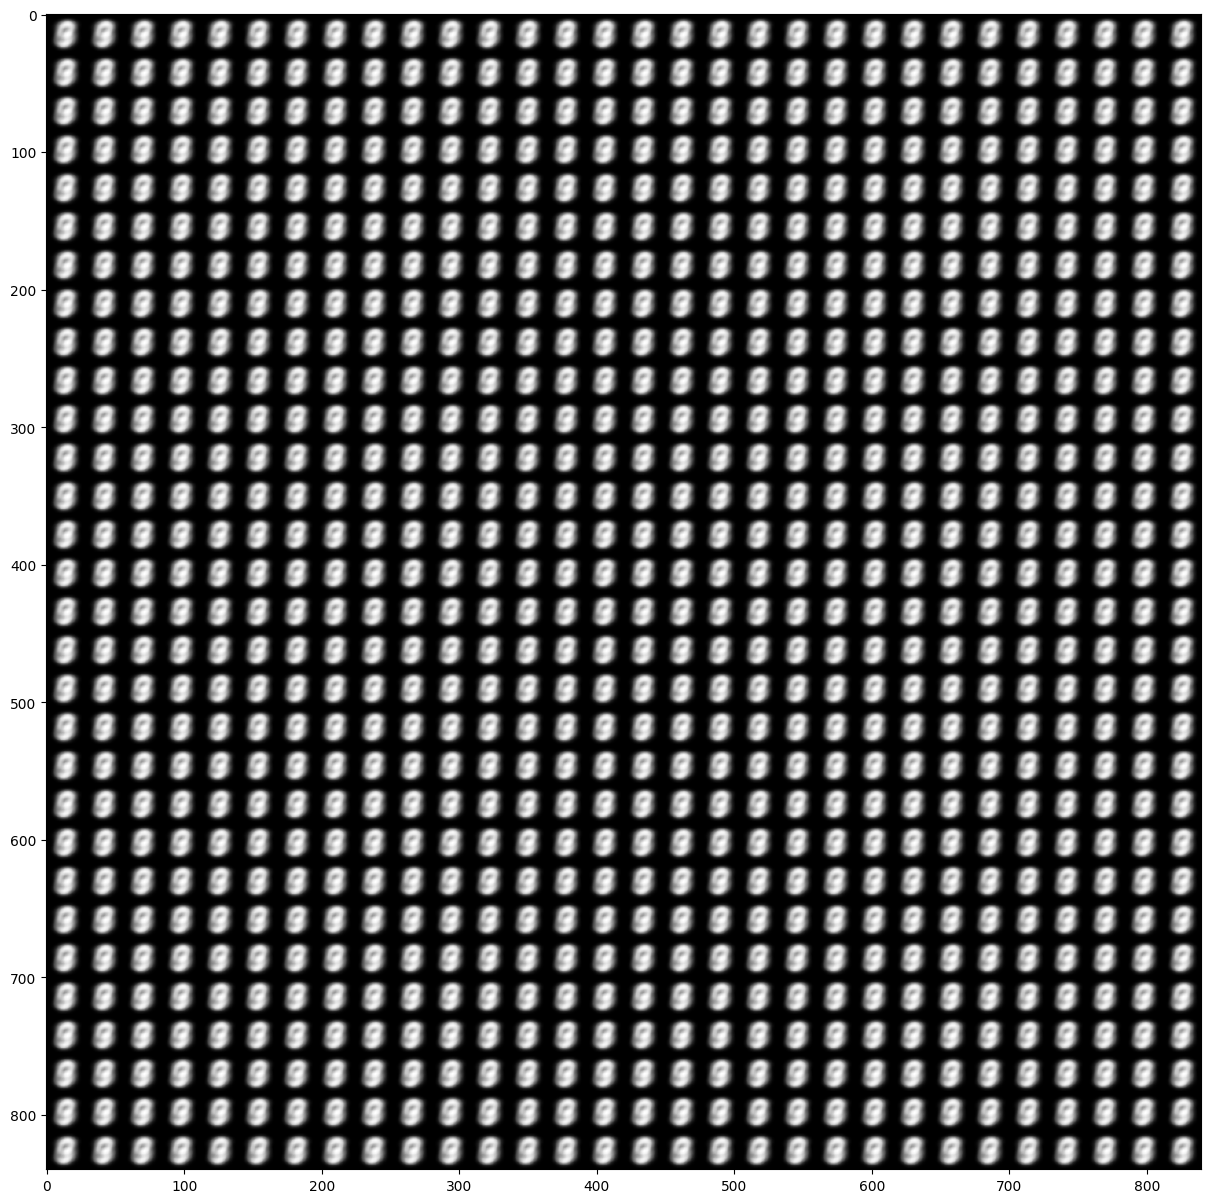

In [ ]:
def plot_latent_space(decoder, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder(z_sample)
            digit = x_decoded.numpy().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

plot_latent_space(vae.decoder)

In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install -U accelerate

#
#BERT ET CHAT GPT
#

#Transformers
Ce code utilise la bibliothèque transformers de Hugging Face pour charger un modèle BERT pré-entraîné et l'utiliser pour une tâche de classification de séquences.
Chargement et Initialisation : Les bibliothèques nécessaires sont importées, et le tokeniseur et le modèle BERT pré-entraîné sont chargés.
Préparation des Données : Les textes et les étiquettes sont définis, puis tokenisés en utilisant le tokeniseur BERT, avec padding et troncature pour gérer les longueurs des séquences.
Configuration de l'Entraînement : Les arguments d'entraînement sont définis, et une instance du Trainer est créée avec le modèle et les données d'entraînement.
Entraînement du Modèle : Le modèle est entraîné sur les données fournies.
Prédiction : Le modèle est utilisé pour effectuer des prédictions sur les données d'entrée tokenisées.
"""
#Voici une explication détaillée de chaque étape :
"""

#Importation des Bibliothèques Nécessaires
"""
from transformers import BertTokenizer, BertForSequenceClassification : Importe les classes nécessaires pour le tokeniseur et le modèle de classification de séquences BERT.
from transformers import Trainer, TrainingArguments : Importe les classes nécessaires pour entraîner le modèle en utilisant l'API Trainer de Hugging Face.
import torch : Importe la bibliothèque PyTorch, utilisée ici pour la manipulation des tenseurs.
"""
#Chargement du Tokenizer et du Modèle BERT Pré-entraîné
"""
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') : Charge le tokeniseur pré-entraîné BERT de base non-casé (bert-base-uncased). Le tokeniseur convertit le texte en identifiants de tokens compatibles avec le modèle BERT.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased') : Charge le modèle BERT pré-entraîné avec une tête de classification de séquences pour des tâches de classification.
"""
#Préparation des Données
"""
texts = ["This is a positive example.", "This is a negative example."] : Définit un petit ensemble de textes pour la classification.
labels = [1, 0] : Définit les étiquettes associées aux textes (1 pour positif, 0 pour négatif).
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True) : Tokenise les textes en utilisant le tokeniseur BERT :
return_tensors='pt' : Retourne les tenseurs PyTorch.
padding=True : Ajoute du padding pour que toutes les séquences aient la même longueur.
truncation=True : Tronque les séquences trop longues pour correspondre à la longueur maximale autorisée par le modèle BERT.
"""
#Entraînement du Modèle
"""
training_args = TrainingArguments(output_dir='./results', num_train_epochs=3, per_device_train_batch_size=4) : Définit les arguments d'entraînement :
output_dir='./results' : Spécifie le répertoire où les résultats de l'entraînement seront sauvegardés.
num_train_epochs=3 : Définit le nombre d'époques d'entraînement à 3.
per_device_train_batch_size=4 : Définit la taille de lot par appareil (GPU/CPU) à 4.
trainer = Trainer(model=model, args=training_args, train_dataset=(inputs, torch.tensor(labels))) : Crée une instance du Trainer avec le modèle, les arguments d'entraînement et les données d'entraînement.
trainer.train() : Entraîne le modèle sur les données fournies.
"""
#Prédictions
predictions = model(inputs['input_ids']) : Utilise le modèle pour effectuer des prédictions sur les textes tokenisés (convertis en identifiants de tokens).



#Bert

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Charger le tokenizer et le modèle pré-entraîné BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Préparation des données
texts = ["This is a positive example.", "This is a negative example."]
labels = [1, 0]
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

# Entraînement du modèle
training_args = TrainingArguments(output_dir='./results', num_train_epochs=3, per_device_train_batch_size=4)
trainer = Trainer(model=model, args=training_args, train_dataset=(inputs, torch.tensor(labels)))
trainer.train()

# Prédiction
predictions = model(inputs['input_ids'])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

#ChatGPT

#Ce code utilise la bibliothèque transformers de Hugging Face pour charger un modèle GPT-2 pré-entraîné et générer du texte à partir d'une phrase d'entrée donnée
"""
Chargement et Initialisation : Les bibliothèques nécessaires sont importées, et le tokeniseur et le modèle GPT-2 pré-entraîné sont chargés.
Préparation de l'Entrée : Le texte d'entrée est défini et tokenisé en une séquence d'identifiants de tokens.
Génération de Texte : Le modèle GPT-2 est utilisé pour générer du texte à partir de la séquence tokenisée d'entrée, avec une longueur maximale de 50 tokens.
Décodage et Affichage : La séquence d'identifiants de tokens générée est décodée en une chaîne de caractères lisible, et le texte généré est affiché.
"""


#Voici une explication détaillée de chaque partie du code :
"""
#Importation des Bibliothèques Nécessaires
"""
from transformers import GPT2Tokenizer, GPT2LMHeadModel : Importe les classes nécessaires pour le tokeniseur et le modèle GPT-2. Le GPT2Tokenizer est utilisé pour convertir du texte en identifiants de tokens compatibles avec le modèle GPT-2, et le GPT2LMHeadModel est le modèle GPT-2 avec une tête de langage pour la génération de texte.
"""

#Chargement du Tokenizer et du Modèle GPT-2 Pré-entraîné
"""

Monsieur,

Ce code utilise la bibliothèque transformers de Hugging Face pour charger un modèle GPT-2 pré-entraîné et générer du texte à partir d'une phrase d'entrée donnée. Voici une explication détaillée de chaque partie du code :

#Importation des Bibliothèques Nécessaires
python

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel : Importe les classes nécessaires pour le tokeniseur et le modèle GPT-2. Le GPT2Tokenizer est utilisé pour convertir du texte en identifiants de tokens compatibles avec le modèle GPT-2, et le GPT2LMHeadModel est le modèle GPT-2 avec une tête de langage pour la génération de texte.
Chargement du Tokenizer et du Modèle GPT-2 Pré-entraîné

# Charger le tokenizer et le modèle pré-entraîné GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') : Charge le tokeniseur pré-entraîné GPT-2. Ce tokeniseur convertit le texte en une séquence d'identifiants de tokens.
model = GPT2LMHeadModel.from_pretrained('gpt2') : Charge le modèle GPT-2 pré-entraîné avec une tête de langage pour la génération de texte.

#Génération de Texte
"""
input_text = "Once upon a time," : Définit une phrase d'entrée pour la génération de texte.
input_ids = tokenizer.encode(input_text, return_tensors='pt') : Tokenise le texte d'entrée en une séquence d'identifiants de tokens et retourne un tenseur PyTorch (return_tensors='pt').
"""

#Génération
"""
output = model.generate(input_ids, max_length=50, num_return_sequences=1) : Utilise le modèle GPT-2 pour générer du texte à partir de la séquence d'identifiants de tokens :
input_ids : La séquence tokenisée d'entrée.
max_length=50 : La longueur maximale de la séquence générée est de 50 tokens.
num_return_sequences=1 : Le nombre de séquences de texte à générer (ici, une seule).
"""

#Décodage et affichage
generated_text = tokenizer.decode(output[0], skip_special_tokens=True) : Décode la séquence d'identifiants de tokens générée en une chaîne de caractères (texte lisible) :
output[0] : Sélectionne la première (et unique) séquence générée.
skip_special_tokens=True : Ignore les tokens spéciaux utilisés par le modèle (comme les tokens de début et de fin de séquence).
print(generated_text) : Affiche le texte généré.

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Charger le tokenizer et le modèle pré-entraîné GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Génération de texte
input_text = "Once upon a time,"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
output = model.generate(input_ids, max_length=50, num_return_sequences=1)

# Affichage du texte généré
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a
